## Old

In [ ]:
import numpy as np
np.bool = np.bool_
np.complex = np.complex128

from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid
from RealESRGAN import RealESRGAN
import torch

device = "cuda:7"

pipeline_image2image = AutoPipelineForImage2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to(device)

model = RealESRGAN(device, scale=4)
model.load_weights('weights/RealESRGAN_x4.pth', download=True)

In [2]:
from PIL import Image
import numpy as np
import os

def load_stl10(root_dir: str = "stl10_binary"):

    path_to_images = os.path.join(root_dir, "train_X.bin")
    path_to_labels = os.path.join(root_dir, "train_y.bin")
    
    with open(path_to_images, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(images, (-1, 3, 96, 96))
        train_images = np.transpose(images, (0, 3, 2, 1))
    
    with open(path_to_labels, 'rb') as f:
        train_labels = np.fromfile(f, dtype=np.uint8) - 1
    
    path_to_images = os.path.join(root_dir, "test_X.bin")
    path_to_labels = os.path.join(root_dir, "test_y.bin")
    
    with open(path_to_images, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(images, (-1, 3, 96, 96))
        test_images = np.transpose(images, (0, 3, 2, 1))
    
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        test_labels = labels - 1

    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_stl10()

  0%|          | 0/1 [00:00<?, ?it/s]

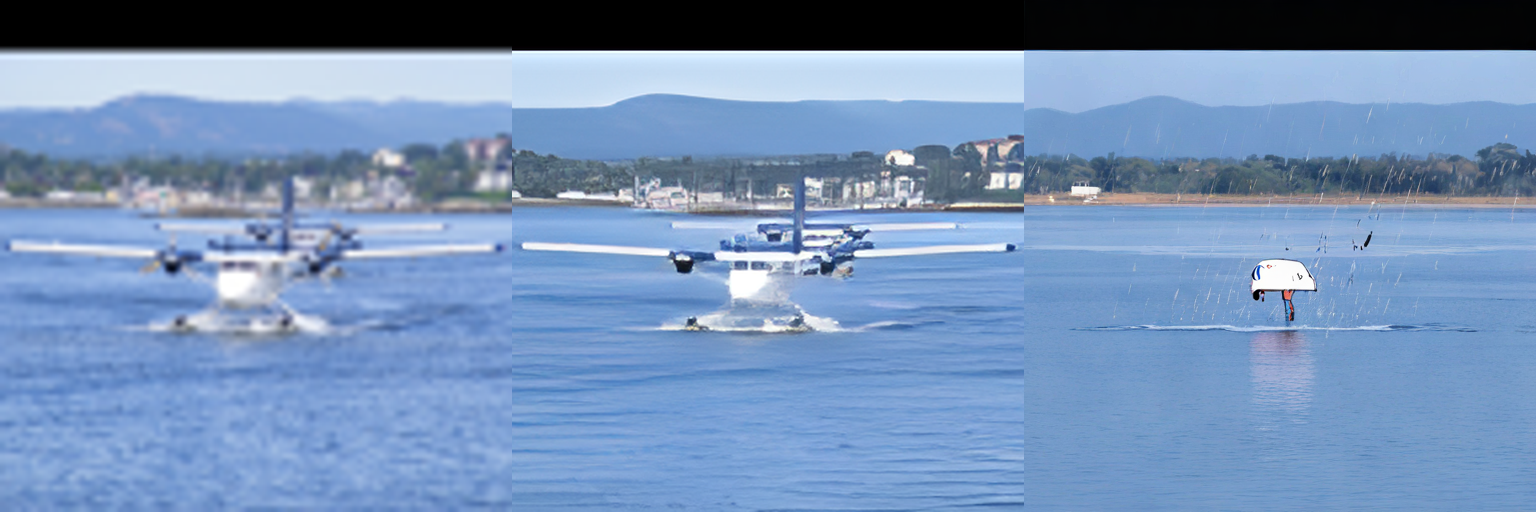

In [17]:
idx = np.random.randint(0, train_images.shape[0])
img = Image.fromarray(train_images[idx].astype(np.uint8))
# img = img.resize((512, 512))

prompt = "make it rainy"

sr_image = model.predict(img).resize((512, 512), Image.Resampling.LANCZOS)
image = pipeline_image2image(
    prompt,
    image=sr_image,
    strength=0.5,
    guidance_scale=0.0,
    num_inference_steps=2
).images[0]
make_image_grid([img.resize((512, 512)), sr_image, image], rows=1, cols=3)

In [ ]:
from aug.automold import add_rain, add_snow, add_fog, add_autumn

def shift(image, domain):
    if domain == "rain":
        return add_rain(image, rain_type = 'torrential')
    elif domain == "fog":
        return add_fog(image, fog_coeff=1.0)
    elif domain == "snow":
        return add_snow(image, snow_coeff=0.05)
    elif domain == "autumn":
        return add_autumn(image)
    return image

train_images, train_labels, test_images, test_labels = load_stl10()
images = [np.stack([np.array(model.predict(img).resize((128, 128), Image.Resampling.LANCZOS)) for img in test_images[:4]])]
for domain in ["rain", "fog", "autumn"]:
    images.append(np.stack([shift(img, domain) for img in images[0]], axis=0))
images = np.stack(images, axis=0)

import matplotlib.pyplot as plt

column_names = ["base", "rain", "fog", "autumn"]
row_names = ["horse"]
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(images[j, i].astype(int))
        axs[i, j].axis('off')
for ax, col in zip(axs[0], column_names):
    ax.set_title(col, fontsize=12)
plt.tight_layout()
plt.savefig("fig.png")
plt.show()

In [ ]:
import imgaug.augmenters as iaa
rain = iaa.Rain(speed=(0.1, 0.3))
fog = iaa.Fog()
snow = iaa.Snowflakes(flake_size=(0.2, 0.7), speed=(0.007, 0.03))

# images = [np.stack([np.array(model.predict(img).resize((96, 96), Image.Resampling.LANCZOS)) for img in test_images[:4]])]
images = [test_images[:4]]
images.append(rain(images=images[0]))
images.append(fog(images=images[0]))
images.append(snow(images=images[0]))
images = np.stack(images, axis=0)

import matplotlib.pyplot as plt

column_names = ["base", "rain", "fog", "snow"]
row_names = ["horse"]
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(images[j, i].astype(int))
        axs[i, j].axis('off')
for ax, col in zip(axs[0], column_names):
    ax.set_title(col, fontsize=12)
plt.tight_layout()
plt.savefig("fig.png")
plt.show()

## Imgaug Augmentations

In [2]:
import numpy as np
np.bool = np.bool_
np.complex = np.complex128
# import imgaug.augmenters as iaa
from PIL import Image
import os
from tqdm.notebook import tqdm
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR, StepLR

import torchvision
from torchvision import transforms as tt

device = "cuda:7"
dtype = torch.float16
batch_size = 256
num_workers = 8
train_domain = "base"
eval_domains = ["base", "rain", "fog", "snow"]
eval_domains = ["rain"]

def load_stl10(root_dir: str = "stl10_binary"):

    path_to_images = os.path.join(root_dir, "train_X.bin")
    path_to_labels = os.path.join(root_dir, "train_y.bin")
    
    with open(path_to_images, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(images, (-1, 3, 96, 96))
        train_images = np.transpose(images, (0, 3, 2, 1))
    
    with open(path_to_labels, 'rb') as f:
        train_labels = np.fromfile(f, dtype=np.uint8) - 1
    
    path_to_images = os.path.join(root_dir, "test_X.bin")
    path_to_labels = os.path.join(root_dir, "test_y.bin")
    
    with open(path_to_images, 'rb') as f:
        images = np.fromfile(f, dtype=np.uint8)
        images = np.reshape(images, (-1, 3, 96, 96))
        test_images = np.transpose(images, (0, 3, 2, 1))
    
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        test_labels = labels - 1

    return train_images, train_labels, test_images, test_labels

class STL10Dataset(Dataset):
    def __init__(self, images, labels, domain="base"):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.domain = domain
        self.domains = ["base", "rain", "fog", "snow"]
        stats = ((113.911194, 112.1515, 103.69485), (51.854874, 51.261967, 51.842403))
        self.tfms = tt.Compose([
            tt.ToTensor(),
            tt.Normalize(stats[0], stats[1])
        ])
        self.rain = iaa.Rain(speed=(0.004, 0.2), nb_iterations=1, drop_size=(0.0001, 0.0001))
        self.fog = iaa.Fog()
        self.snow = iaa.Snowflakes(flake_size=(0.2, 0.7), speed=(0.007, 0.03))

    def __len__(self):
        if self.domain == "all":
            return len(self.domains) * len(self.images)
        return len(self.images)

    def __getitem__(self, idx):

        if self.domain == "all":
            d = idx // len(self.images)
            idx = idx % len(self.images)
            domain = self.domains[d]
        else:
            domain = self.domain
        
        image = self.images[idx]
        label = self.labels[idx]

        image = self.shift(image, domain)
        
        image[np.isnan(image)] = 0

        image = self.tfms(image)

        return image, label

    def shift(self, image, domain):
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_LANCZOS4)
        if domain == "rain":
            return self.rain(image=image)
        elif domain == "fog":
            image = self.fog(image=image)
            image = self.fog(image=image)
            return self.fog(image=image)
        elif domain == "snow":
            return self.snow(image=image)
        elif domain == "base":
            return image
        return image

def evaluate(model, batch_size, num_workers, domains, device, dtype):
    
    train_images, train_labels, test_images, test_labels = load_stl10()
    criterion = torch.nn.CrossEntropyLoss()

    model.eval()
    model.to(device).to(dtype)
    result = {}

    for domain in domains:
        
        test_dataset = STL10Dataset(test_images, test_labels, domain=domain)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        total_loss = 0
        total = 0
        correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                inputs, labels = images.to(device).to(dtype), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        result[domain] = {
            "loss": total_loss / total,
            "accuracy": correct / total
        }

    return result

model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load("./ckpts/resnet50_base.pth"))
model.to(device).to(dtype)

result = evaluate(
    model,
    batch_size = batch_size,
    num_workers = num_workers,
    domains = eval_domains,
    device = device,
    dtype = dtype
)
print([result[domain]["accuracy"] for domain in eval_domains])

NameError: name 'iaa' is not defined

In [ ]:
## Benchmarks
## [0.96825, 0.106875, 0.146375, 0.146125]
## Domain          base   rain   fog   snow
## ResNet50_base  92.82  10.68  14.63  14.61
## ResNet50_rain 

## Layer Norm

In [6]:
import torchvision
import torch

device = "cuda:7"
dtype = torch.float32

def load_model(domain):
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    model.load_state_dict(torch.load(f"./ckpts/resnet50_{domain}.pth"))
    return model.to(device).to(dtype)

def sub(model1, model2):
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    model.to(device).to(dtype)
    m_sd = model.state_dict()
    m1_sd = model1.state_dict()
    m2_sd = model2.state_dict()
    for key in m_sd:
        m_sd[key] = m1_sd[key] - m2_sd[key]
    model.load_state_dict(m_sd)
    return model

base = load_model("base")
rain  = load_model("rain")

tv = sub(base, rain)
tv_state = tv.state_dict()
for key in tv_state:
    n = torch.norm(tv_state[key].to(dtype))
    